In [66]:
import json
import os.path as osp
from utils.path_utils import DATA_DIR
import numpy as np
from rapidfuzz import fuzz
from scipy.optimize import linear_sum_assignment

place_ids = ["ChIJO79pfG7Kj4ARTnmoiEbJKEk", "ChIJT2NxLBPKj4ARRivowJnL3Wg", "ChIJw1N0TPq1j4ARiWgSpsEurvo"]

In [50]:
def evaluate(gt, pred):
    cost_matrix = []
    for gt_item in gt:
        cost_row = []
        for pred_item in pred:
            score = fuzz.ratio(gt_item['name'].lower(), pred_item['name'].lower())
            cost = 100 - score  # convert to cost
            cost_row.append(cost)
        cost_matrix.append(cost_row)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    name_similarity = 0
    desc_similarity = 0
    price_correct = 0
    for i, j in zip(row_ind, col_ind):
        name_similarity += fuzz.ratio(gt[i]['name'].lower(), pred[j]['name'].lower())
        desc_similarity += fuzz.ratio(gt[i]['description'].lower(), pred[j]['description'].lower())
        if gt[i]['price'] == pred[j]['price']:
            price_correct += 1

    result_dict = {
        'name_similarity': name_similarity/len(gt),
        'desc_similarity': desc_similarity/len(gt),
        'price_precision': 100*price_correct/len(pred),
        'price_recall': 100*price_correct/len(gt)
    }

    return cost_matrix, result_dict


In [64]:
# model = "gemini-25-flash"
model = "gemini-3-flash-preview"

for n_cluster in [2, 4, 10]:
    for resize_side in [512, 1024, 2048, 9999]:
    
        result_dict_aggregated = {"name_similarity": [], "desc_similarity": [], "price_precision": [], 'price_recall': []}
        for place_id in place_ids:
            with open(osp.join(DATA_DIR, 'byproduct', '12-menu_extracted', 'gt', f'{place_id}.json'), 'r') as f:
                gt = json.load(f)
            
            pred_file = osp.join(DATA_DIR, "byproduct", "12-menu_extracted", f"{place_id}-{model}-c{n_cluster}-s{resize_side}.json")
            if not osp.exists(pred_file): continue

            with open(pred_file, "r") as f:
                pred = json.load(f)

            cost_matrix, result_dict = evaluate(gt, pred)
            for k, v in result_dict.items():
                result_dict_aggregated[k].append(v)
        
        print(f"c{n_cluster}-s{resize_side}", end = "  ")
        for k, v in result_dict_aggregated.items():
            # print(f"{k}: {np.mean(v):.2f}", end="    ")

            print(f"{np.mean(v):.0f}", end=", ")
        print()
    print()

c2-s512  nan, nan, nan, nan, 
c2-s1024  100, 95, 86, 88, 
c2-s2048  nan, nan, nan, nan, 
c2-s9999  99, 99, 88, 90, 

c4-s512  89, 87, 98, 89, 
c4-s1024  100, 99, 98, 100, 
c4-s2048  100, 99, 98, 100, 
c4-s9999  100, 98, 100, 100, 

c10-s512  100, 98, 98, 100, 
c10-s1024  100, 98, 91, 100, 
c10-s2048  100, 99, 100, 100, 
c10-s9999  100, 98, 96, 99, 



In [67]:
place_id = place_ids[0]
model = "gemini-3-flash-preview"
n_cluster = 4
resize_side = 1024

with open(osp.join(DATA_DIR, 'byproduct', '12-menu_extracted', 'gt', f'{place_id}.json'), 'r') as f:
    gt = json.load(f)

pred_file = osp.join(DATA_DIR, "byproduct", "12-menu_extracted", f"{place_id}-{model}-c{n_cluster}-s{resize_side}.json")
if not osp.exists(pred_file): 
    print(f"{pred_file} does not exist")

with open(pred_file, "r") as f:
    pred = json.load(f)

cost_matrix, result_dict = evaluate(gt, pred)
print(result_dict)

{'name_similarity': 100.0, 'desc_similarity': 99.31023658472112, 'price_precision': 92.85714285714286, 'price_recall': 100.0}


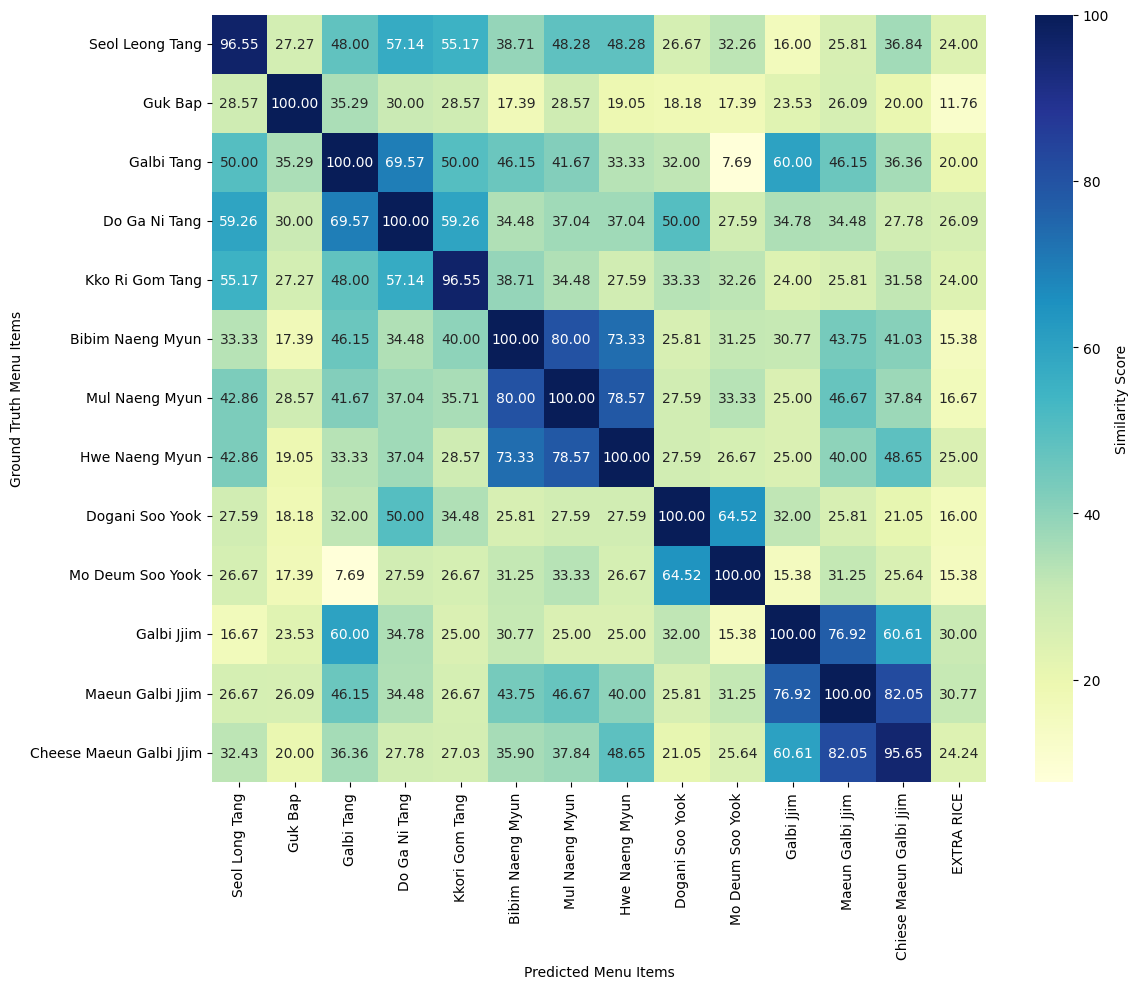

In [60]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

cost_matrix = np.array(cost_matrix)
df = pd.DataFrame(100-cost_matrix, index=[item['name'] for item in gt], columns=[item['name'] for item in pred])

plt.figure(figsize=(12, 10))
sns.heatmap(df, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': 'Similarity Score'})
plt.xlabel('Predicted Menu Items')
plt.ylabel('Ground Truth Menu Items')
plt.tight_layout()
plt.show()

# Create Ground Truth json

In [18]:

place_id = place_ids[2]

with open(osp.join(DATA_DIR, 'byproduct', '12-menu_extracted', f'{place_id}-gemini-3-flash-preview-c4.json'), 'r') as f:
    data = json.load(f)

print(data[0].keys())
ground_truth = [{k: v for k, v in entry.items() if k in ['name', 'price', 'description']} for entry in data]
print(ground_truth)

with open(osp.join(DATA_DIR, 'byproduct', '12-menu_extracted', 'gt', f'{place_id}.json'), 'w') as f:
    json.dump(ground_truth, f, indent=2)

dict_keys(['name', 'nicknames', 'price', 'options', 'description', 'ingredients_by_category', 'dietary_labels'])
[{'name': 'HAKATA TONKOTSU', 'price': 17.5, 'description': 'Hakata Style Ramen with Rich Pork Broth. Chashu pork (simmered pork belly), seasoned soft boiled egg, green onions, kikurage mushrooms, bean sprouts, pickled ginger, and sesame seeds.'}, {'name': 'HAKATA TONKOTSU DX', 'price': 21.5, 'description': 'Hakata Style Ramen with Rich Pork Broth. Regular toppings (chashu pork, seasoned soft boiled egg, green onions, kikurage mushrooms, bean sprouts, pickled ginger) & buta kakuni (braised thick pork belly), corn, sesame seeds, and nori seaweed*.'}, {'name': 'CHICKEN PAITAN', 'price': 17.5, 'description': 'Chicken Ramen with Rich White "Paitan" Broth. Chashu chicken breast, seasoned soft boiled egg, green onions, kikurage mushrooms, bean sprouts, and sesame seeds.'}, {'name': 'CHICKEN PAITAN DX', 'price': 23.0, 'description': 'Chicken Ramen with Rich White "Paitan" Broth & Gr